## Dataset Loading, Preprocessing

In [ ]:
!pip install gensim --upgrade

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/NLP/03")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset-1.csv		 word2vec.model.syn1neg.npy
dataset-wiki.csv	 word2vec.model.wv.vectors.npy
label_encoder.pickle	 word2vec_wiki_lstm
lang-detect2.ipynb	 word2vec-wiki-lstm.h5
lang-detect-clean.ipynb  word2vec_wiki.model
lang-detect.ipynb	 word2vec_wiki.model.syn1neg.npy
word2vec.model		 word2vec_wiki.model.wv.vectors.npy


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("./dataset-wiki.csv")
df.head(5)

,Text,language
0,; † 1797) war Sohn eines Bauern und ist der St...,deu
1,; 1932 kehrte sich das Stimmenverhältnis zwisc...,deu
2,"; † 1981 in Brunsbüttel), Künstler; lebte und ...",deu
3,; 2014: Mit 2000 Besuchern wies das 5. Festiva...,deu
4,"; † 21. September 1902 in Lübeck), sein Vermögen.",deu


In [ ]:
df['language'].unique()

array(['deu', 'eng', 'fra', 'gle', 'ind', 'ita', 'lat', 'nld', 'por',
       'spa'], dtype=object)

In [ ]:
X = df['Text']
y = df['language']

In [ ]:
def regex_filter(text):
  text = re.sub(r'[!@#$(),n"%^*?:;~`0-9.†]', ' ', text)
  text = re.sub(r'[[]]', ' ', text)
  text = text.lower()
  return text

In [ ]:
# Preprocessing, remove non-lingual tokens

X_c = []

for text in X:
  X_c.append(regex_filter(text))

len(X_c)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Possible nested set at position 1
  This is separate from the ipykernel package so we can avoid doing imports until


291160

## BoW & TfIdf -> NB

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
len(y)

291160

In [ ]:
# Word Embedding

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vec = CountVectorizer(max_features=20000, ngram_range=(1, 1))
vec = TfidfVectorizer(max_features=20000, ngram_range=(1, 1))
X = vec.fit_transform(X_c).toarray()
len(X)

In [ ]:
# Train-Test = 90%-10%

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

In [ ]:
print("Accuracy is :",ac)

In [ ]:
# classification report
print(cr)

In [ ]:
# visualising the confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot = True)
plt.show()

In [ ]:
def predict(text):
  x = vec.transform([text]).toarray() # converting text to bag of words model (Vector)
  lang = model.predict(x) # predicting the language
  lang = le.inverse_transform(lang) # finding the language corresponding the the predicted value
  print(lang[0])

In [ ]:
predict("ada garansi resmi nyaman dipakai lama koneksi bluetooth kuat suaranya jernih desainnya modern")

In [ ]:
# Tokenize X_c

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

X_tokenized = []
for item in X_c:
  X_tokenized.append(word_tokenize(item))

X_tokenized[0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['war',
 'soh',
 'ei',
 'es',
 'bauer',
 'u',
 'd',
 'ist',
 'der',
 'stammvater',
 'der',
 'glocke',
 'gießerdy',
 'astie',
 'oberascher']

In [ ]:
# Word Embedding
print(len(X_tokenized))
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences=X_tokenized, vector_size=200, window=5, min_count=1, workers=4)
w2v_model.train(X_tokenized, total_examples=w2v_model.corpus_count, epochs=10)
w2v_model.save("word2vec_wiki.model")

291160


In [ ]:
list(w2v_model.wv.index_to_key)[:10]

['a', 'de', 'e', 'i', 'o', 'u', 'la', 'g', 'co', 't']

In [ ]:
def word_vector(tokens, size):
  vec = np.zeros(size).reshape((1, size))
  count = 0
  for word in tokens:
    try:
      vec += w2v_model.wv[word].reshape((1, size))
      count += 1
    except KeyError:  # handling the case where the token is not in vocabulary
      continue
  if count != 0:
    vec /= count
  else:
    print('WARNING: all OOV')
  return vec

In [ ]:
wordvec_arrays = np.zeros((len(X_tokenized), 200)) 
for i in range(len(X_tokenized)):
    wordvec_arrays[i,:] = word_vector(X_tokenized[i], 200)
X_vec = pd.DataFrame(wordvec_arrays)
X_vec.shape

(291160, 200)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y = encoder.fit_transform(y)
y.shape

(291160, 10)

In [ ]:
import pickle
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle)

In [ ]:
print(X_vec.shape)
print(y.shape)

(291160, 200)
(291160, 10)


In [ ]:
# Train-Test = 90%-10%

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, train_size=0.9, shuffle=True, random_state=5816)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(262044, 200)
(262044, 10)
(29116, 200)
(29116, 10)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

def build_model(X, y):
    model = Sequential()
    model.add(LSTM(128, input_shape=(200, 1)))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X, y, batch_size=128, epochs=5)
    return model

In [ ]:
model = build_model(X_train, y_train)

Epoch 1/5
2048/2048 [==============================] - 85s 41ms/step - loss: 0.3547 - accuracy: 0.8914
Epoch 2/5
2048/2048 [==============================] - 83s 41ms/step - loss: 0.1370 - accuracy: 0.9600
Epoch 3/5
2048/2048 [==============================] - 83s 41ms/step - loss: 0.1005 - accuracy: 0.9700
Epoch 4/5
2048/2048 [==============================] - 83s 41ms/step - loss: 0.0819 - accuracy: 0.9755
Epoch 5/5
2048/2048 [==============================] - 83s 40ms/step - loss: 0.0692 - accuracy: 0.9795


In [ ]:
model.save('word2vec-wiki-lstm.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 67,850
Trainable params: 67,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
import numpy as np
y_test_max = np.argmax(y_test, axis=1)
y_pred_max = np.argmax(y_pred, axis=1)
y_test_lang = encoder.classes_[y_test_max]
y_pred_lang = encoder.classes_[y_pred_max]

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

ac = accuracy_score(y_test_lang, y_pred_lang)
cm = confusion_matrix(y_test_lang, y_pred_lang)
cr = classification_report(y_test_lang, y_pred_lang)

In [ ]:
print("Accuracy is :", ac)
print(cr)

Accuracy is : 0.9799079543893392
              precision    recall  f1-score   support

         deu       0.98      0.98      0.98      2939
         eng       0.98      0.97      0.98      2906
         fra       0.99      0.98      0.99      2893
         gle       0.99      0.99      0.99      2942
         ind       0.99      0.99      0.99      2949
         ita       0.98      0.98      0.98      2808
         lat       0.94      0.97      0.95      2920
         nld       0.98      0.98      0.98      3007
         por       0.99      0.96      0.97      2860
         spa       0.97      0.98      0.98      2892

    accuracy                           0.98     29116
   macro avg       0.98      0.98      0.98     29116
weighted avg       0.98      0.98      0.98     29116



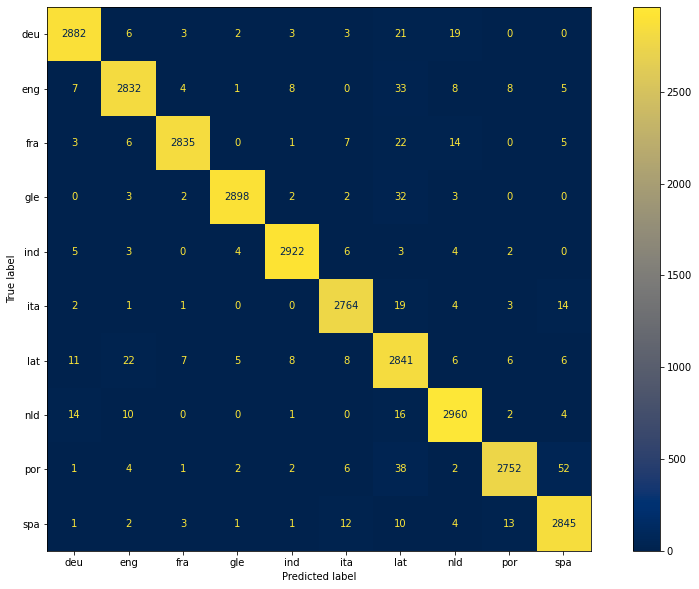

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
fig, ax = plt.subplots(figsize=(15,10))
cmp.plot(cmap='cividis', ax=ax, values_format='')

In [ ]:
def predict(text):
  clean = regex_filter(text)
  x = word_vector(word_tokenize(clean), 200)
  lang = model.predict(x)
  pred = np.zeros_like(lang)
  pred[np.arange(len(lang)), lang.argmax(1)] = 1
  pred_lang = encoder.inverse_transform(pred)
  print(pred_lang[0])

In [ ]:
predict("ada garansi resmi nyaman dipakai lama koneksi bluetooth kuat suaranya jernih desainnya modern")

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
ind


In [ ]:
encoder.classes_

array(['deu', 'eng', 'fra', 'gle', 'ind', 'ita', 'lat', 'nld', 'por',
       'spa'], dtype='<U3')